It is highly recommended to use a powerful **GPU**, you can use it for free uploading this notebook to [Google Colab](https://colab.research.google.com/notebooks/intro.ipynb).
<table align="center">
 <td align="center"><a target="_blank" href="https://colab.research.google.com/github/ezponda/intro_deep_learning/blob/main/class/NLP/Image_search.ipynb">
        <img src="https://colab.research.google.com/img/colab_favicon_256px.png"  width="50" height="50" style="padding-bottom:5px;" />Run in Google Colab</a></td>
  <td align="center"><a target="_blank" href="https://github.com/ezponda/intro_deep_learning/blob/main/class/NLP/Image_search.ipynb">
        <img src="https://github.githubassets.com/images/modules/logos_page/GitHub-Mark.png"  width="50" height="50" style="padding-bottom:5px;" />View Source on GitHub</a></td>
</table>

# Image search

In this guide, we will delve into the realm of image search through the utilization of Sentence Transformers. This entails the mapping of images and text descriptions into a unified vector space, facilitating search and retrieval tasks based on textual descriptions.

To accomplish this, we'll leverage the power of the CLIP (Contrastive Language-Image Pretraining) model, a sophisticated AI model designed by OpenAI. Its core purpose is to cultivate a shared embedding space where both images and text can coexist harmoniously.

In [19]:
!pip install -q sentence-transformers

In [2]:
import sentence_transformers
from sentence_transformers import SentenceTransformer, util
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
from PIL import Image
import glob
import pickle
import zipfile
import copy
from IPython.display import display
from IPython.display import Image as IPImage
import os
from tqdm.autonotebook import tqdm

In [3]:
# Load the sentence transformer model
model_name = 'clip-ViT-B-32'
model = SentenceTransformer(model_name)

In [64]:
import requests
from io import StringIO, BytesIO

def get_image_from_url(url):
    response = requests.get(url)
    img = Image.open(BytesIO(response.content))
    resized_image = img.resize((500, 500))

    return img, resized_image

In [69]:
# Try to get any image from google to test it
img_urls = [
    'https://www.nationalgeographic.com.es/medio/2023/03/17/cenzontle-pajaro_0b18132a_230317114903_800x800.jpg',
    'https://ca-times.brightspotcdn.com/dims4/default/796e6c9/2147483647/strip/true/crop/1970x1108+39+0/resize/1200x675!/quality/75/?url=https%3A%2F%2Fcalifornia-times-brightspot.s3.amazonaws.com%2F12%2Fa5%2F79e097ccf62312d18a025f22ce48%2Fhoyla-recuento-11-cosas-aman-gatos-top-001',
    'https://img.freepik.com/vector-premium/pajaro-azul-dibujos-animados-ondeando-rama-arbol_29190-5977.jpg',
    'https://images.ecestaticos.com/6uBjSmsBorRk6l_IHAxkBS1JCwE=/114x0:1997x1410/1200x900/filters:fill(white):format(jpg)/f.elconfidencial.com%2Foriginal%2F721%2F122%2F714%2F72112271431cb1078c3fe3e75ad5ab41.jpg',
    'https://img.freepik.com/vector-gratis/oso-grizzly-sobre-fondo-blanco_1308-38222.jpg?w=2000',
    'https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcS3GOndt4qWXFnoI4qpYs1TUeyczC7JPM5tPcPUrqFo8WfRCumSIOf4cJQjnmZjm3OVpgs&usqp=CAU'
]

images = []
resized_images = []

for url in img_urls:
    if True:
      image, resized_image = get_image_from_url(url)
      resized_images.append(resized_image)
      images.append(image)
      display(resized_image)
    else:
      print(f'The following URL is not available try another one: {url}')

Output hidden; open in https://colab.research.google.com to view.

In [66]:
img_embeddings = model.encode(images,
                       batch_size=1,
                       convert_to_tensor=True,
                       show_progress_bar=True)
img_embeddings = img_embeddings.cpu()
print(img_embeddings.shape)

Batches:   0%|          | 0/6 [00:00<?, ?it/s]

torch.Size([6, 512])


In [67]:
def image_search(query, model, img_embeddings, images, top_k=2):
    """
    define a function to perform image search, given a query and a list of image embeddings
    """
    query_embedding = model.encode([query])[0]
    similarities = cosine_similarity([query_embedding], img_embeddings)[0]
    indexes = np.argpartition(similarities, -top_k)[-top_k:]
    indexes = indexes[np.argsort(-similarities[indexes])]
    print(f"Input query: {query}")
    print()
    for ind, sim in zip(list(indexes), similarities[indexes].tolist()):
        print('_'*50)
        print(sim)
        display(images[ind])

Input query: Animal with winds

__________________________________________________
0.2412455976009369


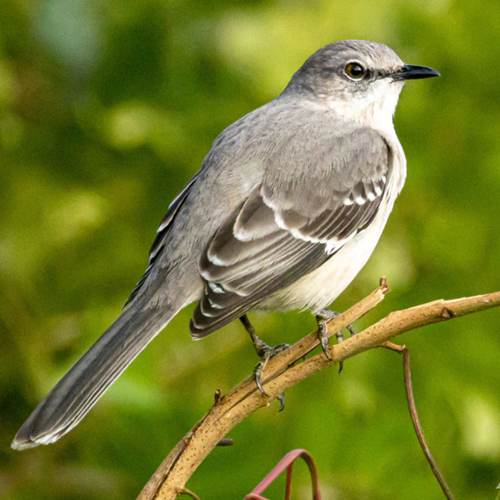

__________________________________________________
0.2395981401205063


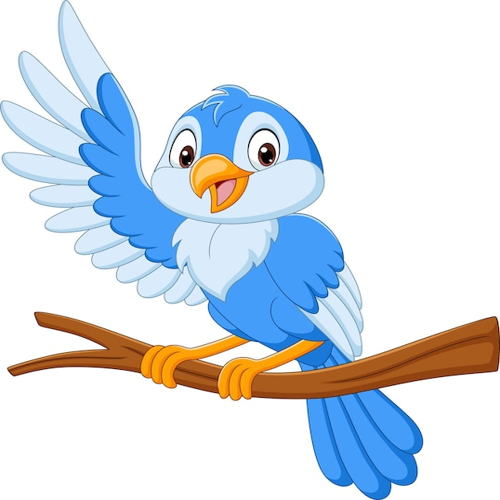

In [70]:
image_search('Animal with winds', model, img_embeddings, resized_images, top_k=2)

Input query: Domestic animal

__________________________________________________
0.24395868182182312


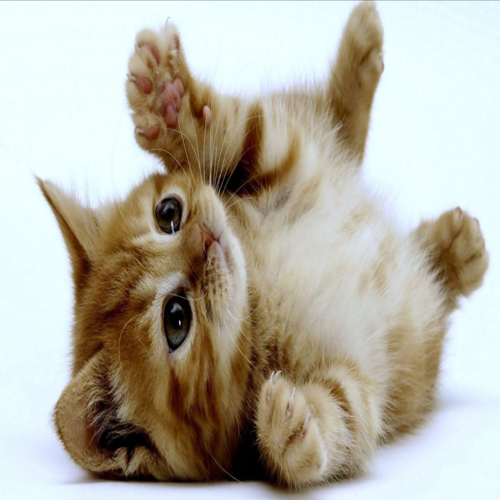

In [74]:
image_search('Domestic animal', model, img_embeddings, resized_images, top_k=1)

Input query: Mammals animal

__________________________________________________
0.25722986459732056


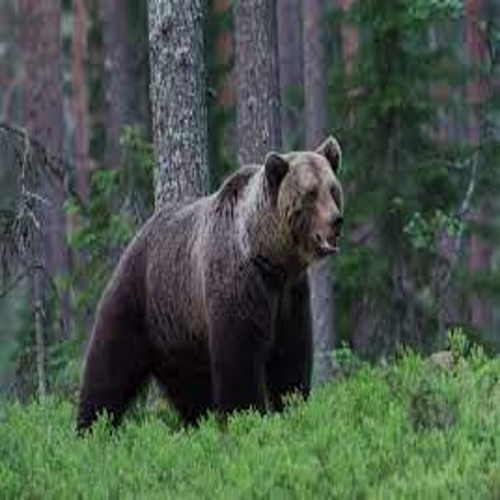

__________________________________________________
0.2537548840045929


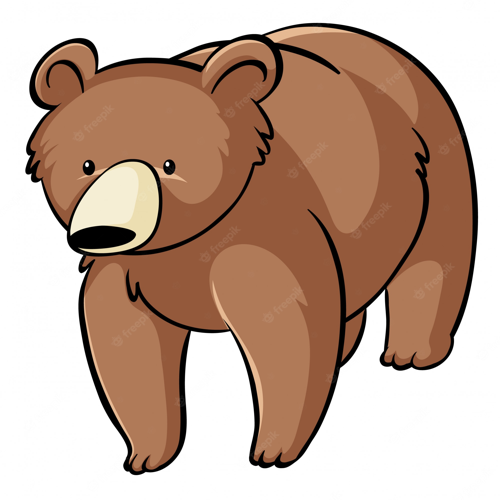

__________________________________________________
0.23568283021450043


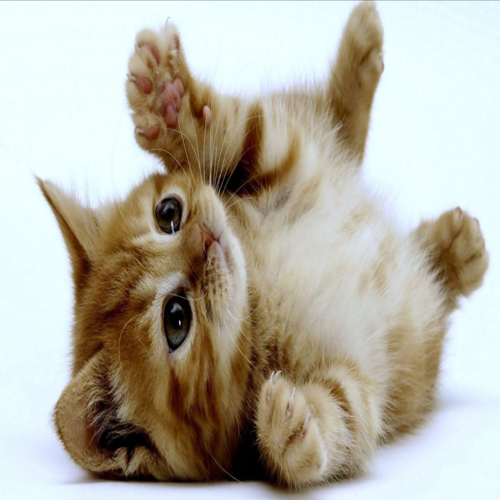

In [75]:
image_search('Mammals animal', model, img_embeddings, resized_images, top_k=3)

Input query: Animal cartoons

__________________________________________________
0.2466026246547699


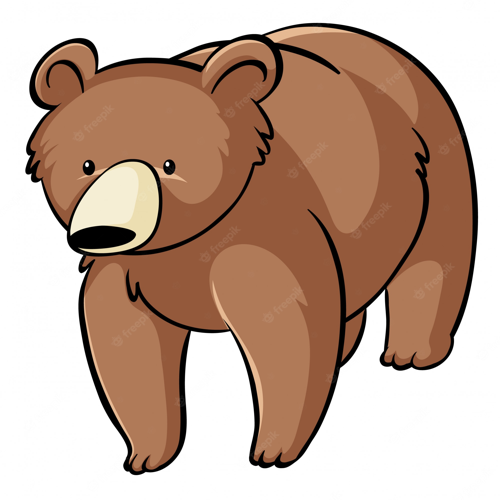

__________________________________________________
0.2405267208814621


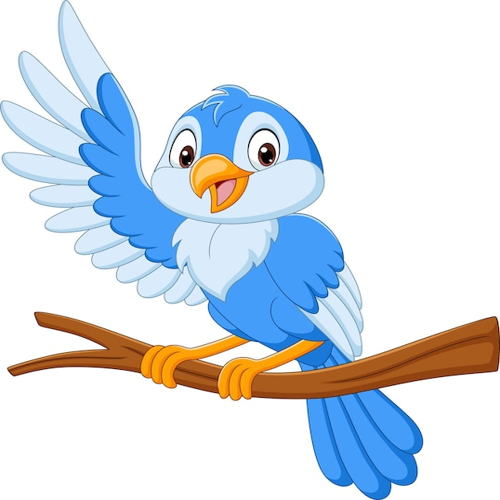

In [73]:
image_search('Animal cartoons', model, img_embeddings, resized_images, top_k=2)